# AB testing in mobile games

## Scope

## Performance metrics

## Dependencies

In [1]:
import sys
CONFIG_DIRECTORY = 'C:\\Users\\billy\\OneDrive\\Documents\\Python Scripts\\1. Portfolio\\ab-testing-cookie-cats\\ab-testing-cookie-cats'
if CONFIG_DIRECTORY not in sys.path:
    sys.path.insert(0, CONFIG_DIRECTORY)

from custom_funcs import summarise_data
import config
from IPython.display import display
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-muted')
import numpy as np
import pandas as pd
from random import sample

## Import data

In [2]:
ab_results = pd.read_csv(config.file_directory('raw') + 'cookie_cats.csv')
ab_results.head(3)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False


## Data exploration

### Data types

In [3]:
ab_results.dtypes

userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object

### Missing values

In [4]:
ab_results.isnull().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

### Summary statistics

In [5]:
display(ab_results[['sum_gamerounds']].describe())
display(ab_results[['version', 'retention_1', 'retention_7']].describe())

,sum_gamerounds
count,90189.000000
mean,51.872457
std,195.050858
min,0.000000
25%,5.000000
50%,16.000000
75%,51.000000
max,49854.000000


,version,retention_1,retention_7
count,90189,90189,90189
unique,2,2,2
top,gate_40,False,False
freq,45489,50036,73408


### Feature distributions

**Categorical features**

In [ ]:
def summarise_data(df, column):
    """Outputs the value count for a given column in a dataframe."""
    summary = pd.DataFrame(
        dict(count=df[column].value_counts(),
             perc=round(df[column].value_counts(normalize=True)*100,1)
            )
    )
    summary.loc['All'] = [df[column].value_counts().sum(), 
                          df[column].value_counts(normalize=True).sum()*100]

    return summary

,count,perc
version,,
gate_40,45489.0,50.4
gate_30,44700.0,49.6
All,90189.0,100.0


,count,perc
retention_1,,
False,50036.0,55.5
True,40153.0,44.5
All,90189.0,100.0


,count,perc
retention_7,,
False,73408.0,81.4
True,16781.0,18.6
All,90189.0,100.0


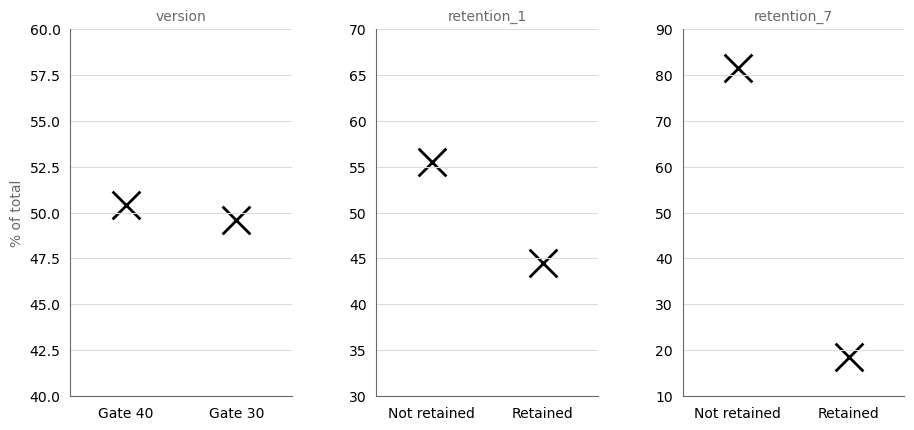

In [6]:
cols = ['version', 'retention_1', 'retention_7']
for col in cols:
    display(summarise_data(ab_results, col))

fig, axes = plt.subplots(nrows=1, ncols=len(cols), figsize= (6.4*len(cols)/2, 4.8))
fig.tight_layout(pad=3.0)

for ax, col in zip(axes, cols):
    data = summarise_data(ab_results, col)
    ax.scatter(data.loc[data.index != 'All'].index,
               data.loc[data.index != 'All', 'perc'],
               marker='x',
               s=400,
               c='black',
               linewidths=2)
    ax.set_xlim([-0.5, 1.5])
    ax.set_ylim([round(min(data.loc[data.index != 'All', 'perc']) - 10, -1),
                 round(max(data.loc[data.index != 'All', 'perc']) + 10, -1)])
    ax.tick_params(bottom=False, left=False)
    if 'retention' in col:
        ax.set_xticks([0, 1], ['Not retained', 'Retained'])
    else:
        ax.set_xticks([0, 1], ['Gate 40', 'Gate 30'])
    ax.grid(True, axis='y', color='gainsboro')
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('dimgray')
    ax.set_title(col, fontsize=10, color='dimgray')
    
axes[0].set_ylabel('% of total', color='dimgray');

**Numerical features**

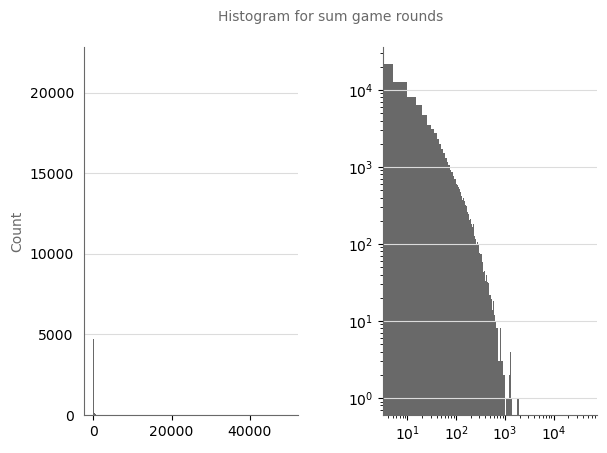

In [7]:
bin_width = 5
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.tight_layout(pad=3.0)

axes[0].hist(ab_results['sum_gamerounds'],
             bins=range(0, ab_results['sum_gamerounds'].max() + bin_width, bin_width),
             color = 'dimgray')   
axes[1].hist(ab_results['sum_gamerounds'],
             bins=range(0, ab_results['sum_gamerounds'].max() + bin_width, bin_width),
             color = 'dimgray')
axes[1].set_yscale('log')
axes[1].set_xscale('log')
axes[0].tick_params(left=False)
axes[0].set_ylabel('Count', color='dimgray');
for ax in axes:
    ax.grid(True, axis='y', color='gainsboro')
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('dimgray')
fig.suptitle('Histogram for sum game rounds', fontsize=10, color='dimgray');

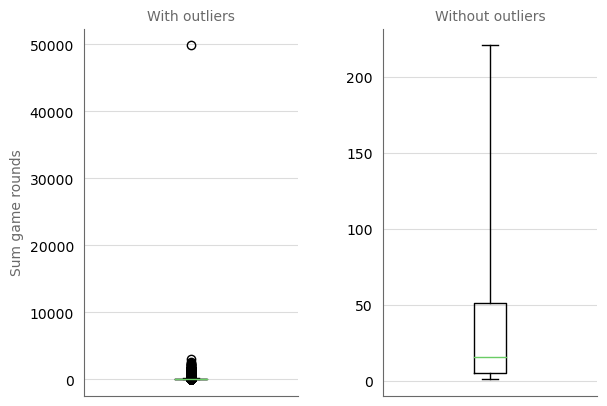

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.tight_layout(pad=3.0)

axes[0].boxplot(ab_results['sum_gamerounds'], whis=[5, 95])
axes[1].boxplot(ab_results['sum_gamerounds'], whis=[5, 95], showfliers=False)
axes[0].set_title('With outliers', fontsize=10, color='dimgray')
axes[0].set_ylabel('Sum game rounds', fontsize=10, color='dimgray')
axes[1].set_title('Without outliers', fontsize=10, color='dimgray')
for ax in axes:
    ax.set_xticks([1], labels=[]);
    ax.tick_params(bottom=False, left=False)
    ax.grid(True, axis='y', color='gainsboro')
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('dimgray')

### Feature relationships

#### Sum game rounds versus version

In [9]:
display(pd.concat([ab_results.loc[ab_results.version == v, 'sum_gamerounds'].describe() for v in ab_results['version'].unique()],
                  axis=1,
                  keys=[v for v in ab_results['version'].unique()]
                 )
       )

,gate_30,gate_40
count,44700.000000,45489.000000
mean,52.456264,51.298776
std,256.716423,103.294416
min,0.000000,0.000000
25%,5.000000,5.000000
50%,17.000000,16.000000
75%,50.000000,52.000000
max,49854.000000,2640.000000


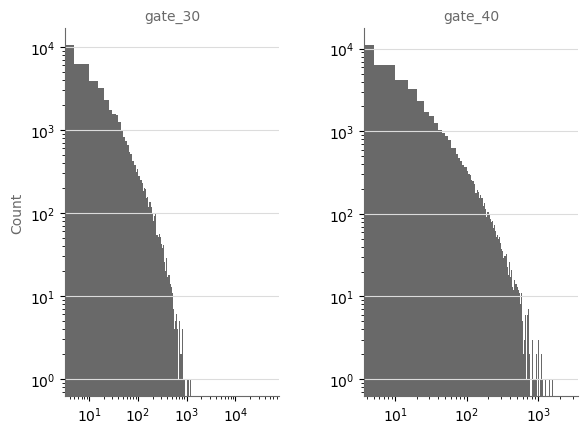

In [10]:
bin_width = 5
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.tight_layout(pad=3.0)

for v, ax in zip(ab_results['version'].unique(), axes):
    ax.hist(ab_results.loc[ab_results.version == v, 'sum_gamerounds'],
            bins=range(0, ab_results.loc[ab_results.version == v, 'sum_gamerounds'].max() + bin_width, bin_width),
            color = 'dimgray')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.grid(True, axis='y', color='gainsboro')
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('dimgray')
    ax.set_title(v, fontsize=10, color='dimgray')
axes[0].set_ylabel('Count', color='dimgray');

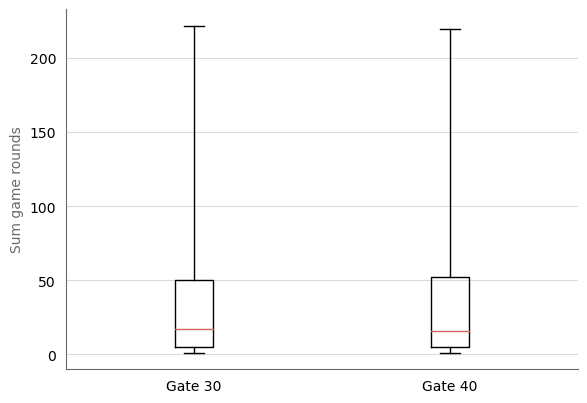

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=1)
ab_results.boxplot(by='version',
                   column='sum_gamerounds',
                   ax=axes,
                   whis=[5, 95],
                   showfliers=False,
                   boxprops=dict(color='k'),
                   whiskerprops=dict(color='k'),
                   capprops=dict(color='k')
                   )
axes.set_xticks([1, 2], labels=['Gate 30', 'Gate 40'])
axes.set_xlabel('')
axes.set_ylabel('Sum game rounds', fontsize=10, color='dimgray')
axes.tick_params(bottom=False, left=False)
axes.grid(False)
axes.grid(True, axis='y', which='major', color='gainsboro')
axes.spines[['top', 'right']].set_visible(False)
axes.spines[['left', 'bottom']].set_color('dimgray')
axes.set_title('')
fig.suptitle('');

#### Retention versus version

In [12]:
def outcomes_func(x, measure):
    """Calculate retention outcome counts and percentages for a given measure. 
    Where x is the raw results DataFrame and measure is either retention_1 or retention_7
    """
    df = x.groupby(by=['version', measure])['userid'].count().rename('count')
    df.index = df.index.rename(['version', 'outcome'])
    df = df.reset_index(level='outcome').join(
        x.groupby(by=['version'])['userid'].count().rename('total'))
    df['perc'] = round(df['count'] / df['total'] * 100, 2)
    
    df = df.set_index('outcome', append=True).drop('total', axis=1)
    df.columns = pd.MultiIndex.from_product([[measure], df.columns])
    return df

retent_outcomes = outcomes_func(ab_results, 'retention_1').join(outcomes_func(ab_results, 'retention_7'))
retent_outcomes.xs(True, level=1, axis=0).xs('perc', level=1, axis=1)

,retention_1,retention_7
version,,
gate_30,44.82,19.02
gate_40,44.23,18.20


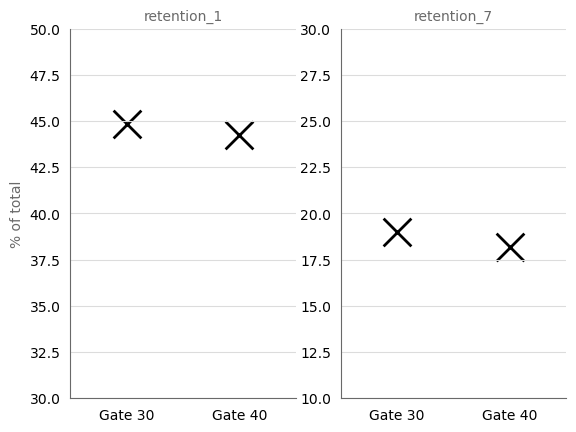

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2)

for ax, measure in zip(axes, ['retention_1', 'retention_7']):
    perc_view = retent_outcomes.xs(True, level=1, axis=0).xs('perc', level=1, axis=1)[measure]
    ax.scatter(perc_view.index,
               perc_view.values,
               marker='x',
               s=400,
               c='black',
               linewidths=2)
    
    ax.set_xlim([-0.5, 1.5])
    ax.set_ylim(
        [round(min(perc_view.values) - 10, -1),
         round(max(perc_view.values) + 10, -1)])
    ax.set_xticks([0, 1], ['Gate 30', 'Gate 40'])
    ax.tick_params(bottom=False, left=False)
    ax.grid(True, axis='y', color='gainsboro')
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('dimgray')
    ax.set_title(measure, fontsize=10, color='dimgray')
axes[0].set_ylabel('% of total', color='dimgray');

## Data cleaning

In [14]:
ab_results = ab_results.loc[ab_results['sum_gamerounds'] != ab_results['sum_gamerounds'].max()]
ab_results = ab_results.reset_index(drop=True)

## Permutation test

In [15]:
def perm_func(x, n_A, n_B):
    """Compute difference in means for """
    n = n_A + n_B
    idx_A = set(sample(range(n), n_A))
    idx_B = set(range(n)) - idx_A
    return x.loc[list(idx_A)].mean() - x.loc[list(idx_B)].mean()

### Game rounds played

In [16]:
display(summarise_data(ab_results, 'version'))

,count,perc
version,,
gate_40,45489.0,50.4
gate_30,44699.0,49.6
All,90188.0,100.0


In [17]:
gate_30_mean = ab_results.loc[ab_results['version'] == 'gate_30', 'sum_gamerounds'].mean()
gate_40_mean = ab_results.loc[ab_results['version'] == 'gate_40', 'sum_gamerounds'].mean()
obs_pct_diff = gate_30_mean - gate_40_mean
print(f'Gate 30 mean: {gate_30_mean}')
print(f'Gate 40 mean: {gate_40_mean}')
print(f'Observed percentage difference: {obs_pct_diff}')

Gate 30 mean: 51.342110561757536
Gate 40 mean: 51.29877552814966
Observed percentage difference: 0.04333503360787461


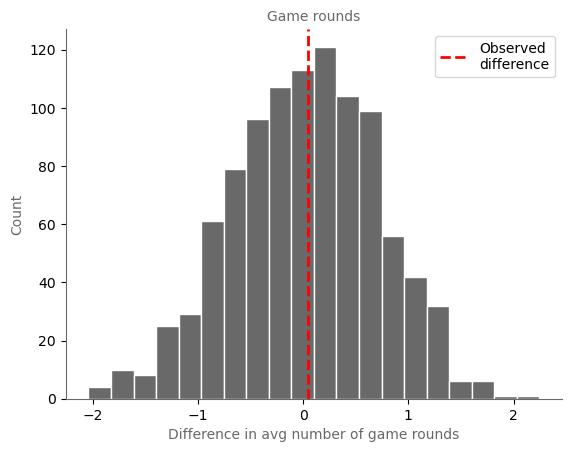

In [18]:
perm_diffs = [perm_func(ab_results['sum_gamerounds'], 44699, 45489) for _ in range(1000)]

fig, axes = plt.subplots()
axes.hist(perm_diffs, bins=20, color = 'dimgray', ec="white", lw=1)
axes.axvline(x=obs_pct_diff, linestyle='--', color='red', lw=2, label='Observed\ndifference')

axes.set_xlabel('Difference in avg number of game rounds', color='dimgray');
axes.set_ylabel('Count', color='dimgray');
axes.set_title('Game rounds', fontsize=10, color='dimgray');
axes.spines[['top', 'right']].set_visible(False);
axes.spines[['left', 'bottom']].set_color('dimgray');
axes.legend();

In [19]:
p_val = np.mean([diff > obs_pct_diff for diff in perm_diffs])
print(f'p-Value: {p_val}')

p-Value: 0.498


### 1 day retention

In [20]:
retent_outcomes = outcomes_func(ab_results, 'retention_1').join(outcomes_func(ab_results, 'retention_7'))
retent_outcomes.xs('retention_1', level=0, axis=1)

count   perc
version outcome              
gate_30 False    24665  55.18
        True     20034  44.82
gate_40 False    25370  55.77
        True     20119  44.23

In [21]:
obs_pct_diff = 44.82 - 44.23
print(f'Observed percentage difference: {obs_pct_diff}')

Observed percentage difference: 0.5900000000000034


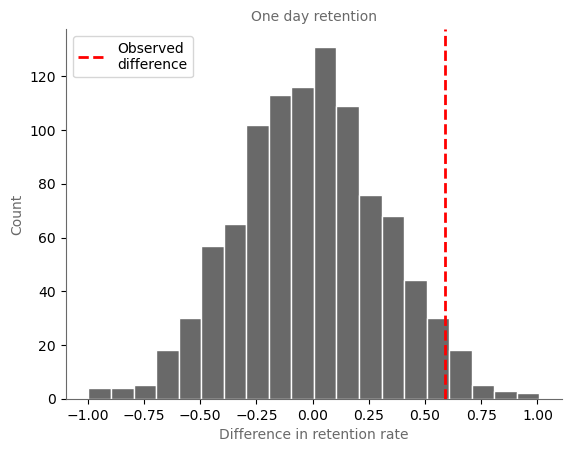

In [22]:
not_retained = [0] * (24665 + 25370)
retained = [1] * (20034 + 20119)
perm_diffs = [100 * perm_func(pd.Series(not_retained + retained), 44699, 45489) for _ in range(1000)]

fig, axes = plt.subplots()
axes.hist(perm_diffs, bins=20, color = "dimgray", ec="white", lw=1)
axes.axvline(x=obs_pct_diff, linestyle='--', color='red', lw=2, label='Observed\ndifference')

axes.set_xlabel('Difference in retention rate', color='dimgray');
axes.set_ylabel('Count', color='dimgray');
axes.set_title('One day retention', fontsize=10, color='dimgray');
axes.spines[['top', 'right']].set_visible(False);
axes.spines[['left', 'bottom']].set_color('dimgray');
axes.legend();

In [23]:
p_val = np.mean([diff > obs_pct_diff for diff in perm_diffs])
print(f'p-Value: {p_val}')

p-Value: 0.031


### 7 day retention

In [24]:
retent_outcomes = outcomes_func(ab_results, 'retention_1').join(outcomes_func(ab_results, 'retention_7'))
retent_outcomes.xs('retention_7', level=0, axis=1)

count   perc
version outcome              
gate_30 False    36198  80.98
        True      8501  19.02
gate_40 False    37210  81.80
        True      8279  18.20

In [25]:
obs_pct_diff = 19.02 - 18.20
print(f'Observed percentage difference: {obs_pct_diff}')

Observed percentage difference: 0.8200000000000003


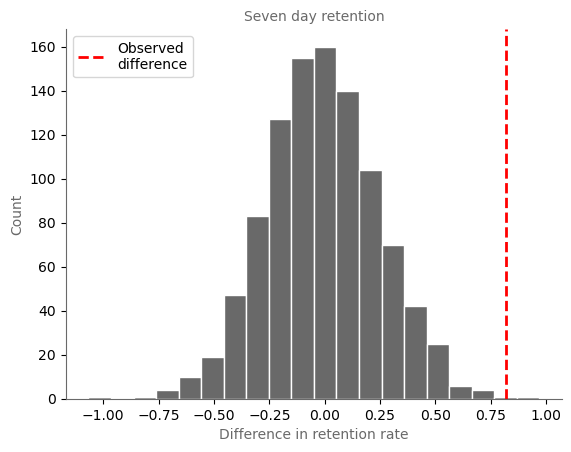

In [26]:
not_retained = [0] * (36198 + 37210)
retained = [1] * (8501 + 8279)
perm_diffs = [100 * perm_func(pd.Series(not_retained + retained), 44699, 45489) for _ in range(1000)]

fig, axes = plt.subplots()
axes.hist(perm_diffs, bins=20, color = "dimgray", ec="white", lw=1)
axes.axvline(x=obs_pct_diff, linestyle='--', color='red', lw=2, label='Observed\ndifference')

axes.set_xlabel('Difference in retention rate', color='dimgray');
axes.set_ylabel('Count', color='dimgray');
axes.set_title('Seven day retention', fontsize=10, color='dimgray');
axes.spines[['top', 'right']].set_visible(False);
axes.spines[['left', 'bottom']].set_color('dimgray');
axes.legend();

In [27]:
p_val = np.mean([diff > obs_pct_diff for diff in perm_diffs])
print(f'p-Value: {p_val}')

p-Value: 0.001


## Conclusion